In [1]:
from math import atan, sin, cos, pi, sqrt
from scipy.constants import g
import numpy as np
from scipy.integrate import RK45

In [2]:
m = 1    # Mass

b = 0.3  # Damping coefficient
h = 0.5  # Height above the x-y plane

L = g  # bob length
R = 0.5  # magnet radius

rmag = sqrt((L+h)**2 + R**2)
θmag = atan(R/(L+h))
ϕmag_list = np.array([(pi/2) * i for i in range(4)])  # -> magnets at (0, R), (0, -R), (-R, 0), (R, 0)
strength = 1
polarity_list = np.array([1,1,1,1]) * strength

## define eqns

In [3]:
def polar_distance(r1_v, r2_v):
    (r1,t1,p1) = r1_v
    (r2,t2,p2) = r2_v
    return sqrt(
                (r1)**2 + (r2)**2
                - 2*(r1)*(r2)*(sin(t1)*sin(t2)*cos(p1-p2) + cos(t1)*cos(t2))
            )

In [4]:
def force_by_magnets(θ, ϕ, θv, ϕv):
    """this is so ugly"""
    distance = lambda ϕmag: polar_distance((L,θ,ϕ), (rmag,θmag,ϕmag))
    
    def force_by_single_magnet_θ(polarity, ϕmag):
        direction_component = cos(θ)*sin(θmag)*cos(ϕ-ϕmag) - sin(θ)*cos(θmag)
        return (polarity/(distance(ϕmag))**5) * direction_component
    
    def force_by_single_magnet_ϕ(polarity, ϕmag):
        direction_component = -sin(θmag)*sin(ϕ-ϕmag)        
        return  (polarity/(distance(ϕmag))**5) * direction_component

    return np.array([
        sum(np.vectorize(force_by_single_magnet_θ)(polarity_list, ϕmag_list)),
        sum(np.vectorize(force_by_single_magnet_ϕ)(polarity_list, ϕmag_list))
    ])

def force_by_gravity(θ, ϕ, θv, ϕv):
    return np.array([
        -m*g*sin(θ),
        0
    ])

def force_of_damping(θ, ϕ, θv, ϕv):
    return -b*L * np.array([
        θv,
        ϕv*sin(θ)
    ])

In [5]:
def ddt(t, y_array):
    θ, ϕ, θv, ϕv = y_array
    force_θ, force_ϕ = (force_by_gravity(θ, ϕ, θv, ϕv)
                        + force_by_magnets(θ, ϕ, θv, ϕv)
                        + force_of_damping(θ, ϕ, θv, ϕv))
    return np.array([
        θv,
        ϕv,
        (force_θ + L*(ϕv**2)*sin(θ)*cos(θ))/L,
        (force_ϕ - 2*L*θv*ϕv*cos(θ))/(L*sin(θ))
    ])

## run pendlum model

In [20]:
starting_conditions = np.array([
    pi/3,
    pi/6,
    0,
    0
])

integrator = RK45(ddt, 0, starting_conditions, t_bound=100, first_step=0.001, max_step=0.01)

In [21]:
ddt(0, starting_conditions)

array([ 0.00000000e+00,  0.00000000e+00, -8.66028839e-01, -9.22905940e-11])

In [22]:
result = []
while not (integrator.status == 'finished'):
    result.append([integrator.t, *integrator.y])
    integrator.step()
result = np.array(result)

In [23]:
to_x = lambda r,θ,ϕ: r*sin(θ)*cos(ϕ)
to_y = lambda r,θ,ϕ: r*sin(θ)*sin(ϕ)
to_z = lambda r,θ,ϕ: -r*cos(θ)

to_cartesian = lambda r,θ,ϕ: [to_x(r,θ,ϕ), to_y(r,θ,ϕ), to_z(r,θ,ϕ)]

In [24]:
trajectory = np.zeros((result.shape[0], 3))
trajectory[:,0] = L*np.sin(result[:,2])*np.cos(result[:,1])
trajectory[:,1] = L*np.sin(result[:,2])*np.sin(result[:,1])
trajectory[:,2] = -L*np.cos(result[:,2])

In [25]:
trajectory

array([[ 2.45166250e+00,  4.24640401e+00, -8.49280803e+00],
       [ 2.45166434e+00,  4.24640295e+00, -8.49280803e+00],
       [ 2.45188474e+00,  4.24627569e+00, -8.49280803e+00],
       ...,
       [-9.78023878e+00, -1.15697698e-06, -7.19245171e-01],
       [-9.79156247e+00, -1.17113019e-06, -5.43772540e-01],
       [-9.79957353e+00, -1.18517510e-06, -3.72481937e-01]])

In [26]:
L*np.cos(result[:,2])*np.cos(result[:,1])

array([4.24640401, 4.2464072 , 4.24678894, ..., 0.71924517, 0.54377254,
       0.37248194])

## graphing

In [27]:
from matplotlib import projections
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.animation as animation

def plot_trajectory(trajectory, magnet_positions):
    
    ax = plt.figure(figsize=(8, 8)).add_subplot(projection='3d')
    # plt.title(f'Magnetic Pendulum Trajectory')
    ax.set_title(f'Magnetic Pendulum Trajectory')
    # Plot the trajectory
    ax.plot(*trajectory.T, label='Pendulum Path', zorder=1)  

    # Plot the magnet positions
    ax.scatter(*zip(*magnet_positions), color='red', label='Magnets', zorder=2)  

    # Plot the final & initial positions of the pendulum
    final_position = trajectory[-1]
    initial_position = trajectory[0]
    ax.scatter(*final_position, color='cyan', label='Final Position', s=10, zorder=3)
    ax.scatter(*initial_position, color='black', label='Initial Position', s=10, zorder=3)

    ax.legend()
    ax.grid(True)
    ax.axis('equal')
    plt.show()

def plot_trajectory_rotate(trajectory, magnet_positions):

    ax = plt.figure(figsize=(8, 8)).add_subplot(projection='3d')
    # plt.title(f'Magnetic Pendulum Trajectory')
    ax.set_title(f'Magnetic Pendulum Trajectory')
    # Plot the trajectory
    ax.plot(*trajectory.T, label='Pendulum Path', zorder=1)  

    # Plot the magnet positions
    ax.scatter(*zip(*magnet_positions), color='red', label='Magnets', zorder=2)  

    # Plot the final & initial positions of the pendulum
    final_position = trajectory[-1]
    initial_position = trajectory[0]
    ax.scatter(*final_position, color='cyan', label='Final Position', s=10, zorder=3)
    ax.scatter(*initial_position, color='black', label='Initial Position', s=10, zorder=3)

    ax.legend()
    ax.grid(True)
    ax.axis('equal')


    # Rotate the axes and update
    while True:
        for angle in range(0, 360):
            # Normalize the angle to the range [-180, 180] for display
            angle_norm = (angle + 180) % 360 - 180
            # Cycle through a full rotation of elevation, then azimuth, roll, and all
            elev = azim = roll = 0
            elev = 13
            azim = angle_norm


            # Update the axis view and title
            ax.view_init(elev, azim, roll)
            plt.title('Elevation: %d°, Azimuth: %d°, Roll: %d°' % (elev, azim, roll))

            plt.draw()
            plt.pause(.001)

def plot_trajectory_animation(trajectory, magnet_positions, dt=0.01):

    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(projection="3d")
    # plt.title(f'Magnetic Pendulum Trajectory')
    ax.set_title(f'Magnetic Pendulum Trajectory')
    # Plot the trajectory
    ax.plot(*trajectory.T, label='Pendulum Path', color='gray', alpha=0.1, zorder=1)  

    # Plot the magnet positions
    ax.scatter(*zip(*magnet_positions), color='red', label='Magnets', zorder=2)  

    # Plot the final & initial positions of the pendulum
    final_position = trajectory[-1]
    initial_position = trajectory[0]
    ax.scatter(*final_position, color='cyan', label='Final Position', s=10, zorder=3)
    ax.scatter(*initial_position, color='black', label='Initial Position', s=10, zorder=3)

    ax.legend()
    ax.grid(True)
    ax.axis('equal') 

    line, = ax.plot([], [], [], 'o-', lw=2)
    trace, = ax.plot([], [], [], '.-', lw=1, ms=2)
    time_template = 'time = %.1f'
    time_text = ax.text(0.05, 0.9, 0.9, '', transform=ax.transAxes)


    def animate(i):
        this = trajectory[i:i+1]
        history = trajectory[:i]

        line.set_data_3d(this.T)
        trace.set_data_3d(history.T)
        time_text.set_text(time_template % (i))
        return line, trace, time_text

    N = len(trajectory)
    ani = animation.FuncAnimation(
        fig, animate, N, interval=dt/3, blit=True)
#     plt.show()
    return ani

In [28]:
magnet_positions = [to_cartesian(rmag, θmag, ϕmag) for ϕmag in ϕmag_list]

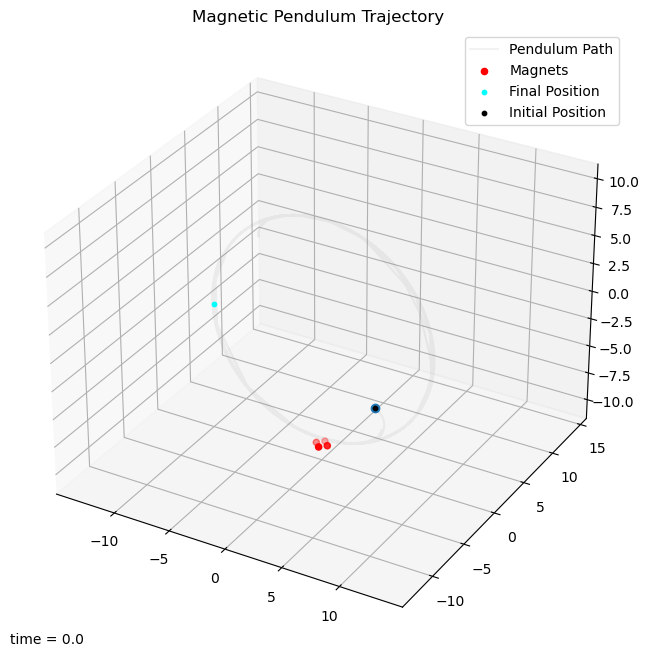

In [29]:
%matplotlib inline
plot_trajectory_animation(trajectory, magnet_positions)

In [32]:
list(result[:,1])

[1.0471975511965976,
 1.0471971182254942,
 1.0471452143023299,
 1.0470069957215535,
 1.0467827279411857,
 1.0464726799245272,
 1.046077124121218,
 1.0455963364500591,
 1.0450305962835724,
 1.044380186434269,
 1.0436453931425993,
 1.0428265060665554,
 1.0419238182728958,
 1.0409376262299626,
 1.0398682298020585,
 1.0387159322453543,
 1.0374810402052923,
 1.0361638637154533,
 1.0347647161978537,
 1.0332839144646375,
 1.03172177872113,
 1.0300786325702143,
 1.0283548030179992,
 1.0265506204807373,
 1.0246664187929582,
 1.0227025352167796,
 1.0206593104523558,
 1.0185370886494267,
 1.0163362174199275,
 1.0140570478516175,
 1.011699934522691,
 1.009265235517325,
 1.006753312442128,
 1.0041645304434414,
 1.0014992582254578,
 0.9987578680691088,
 0.9959407358516822,
 0.9930482410671229,
 0.9900807668469757,
 0.987038699981924,
 0.9839224309438811,
 0.9807323539085883,
 0.9774688667786747,
 0.9741323712071338,
 0.9707232726211693,
 0.9672419802463658,
 0.9636889071311365,
 0.9600644701714022,
